# Dado magnético - Serra do Cabral

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [3]:
def find_index(data):
    '''
    This function returns the index where maximum and minimum are located.
    
    Inputs:
    data - numpy array - values in a grid
    
    Output:
    ind_max - tuple - pair of grid index for maximum values
    ind_min - tuple - pair of grid index for minimum values
    '''
    
    if data.ndim == 1.:
        imax = np.where(data == data.max())
        imin = np.where(data == data.min())
        res_max = imax
        res_min = imin
    else:
        imax, jmax = np.where(data == data.max())
        imin, jmin = np.where(data == data.min())
        res_max = (imax, jmax)
        res_min = (imin, jmin)
    
    # Return the final output
    return res_max, res_min

In [4]:
# Carregar o dado
x, y, z = np.loadtxt('cabral.dat', skiprows = 1, usecols = (0,1,4), unpack=True)

In [5]:
from codes.statistical import analysis
print 'Dado magnetico original:'
_ = analysis(z, 'nT')

Dado magnetico original:
Minimum:    -172.9280 nT
Maximum:    317.3630 nT
Mean value: 10.0603 nT
Variation:  490.2910 nT


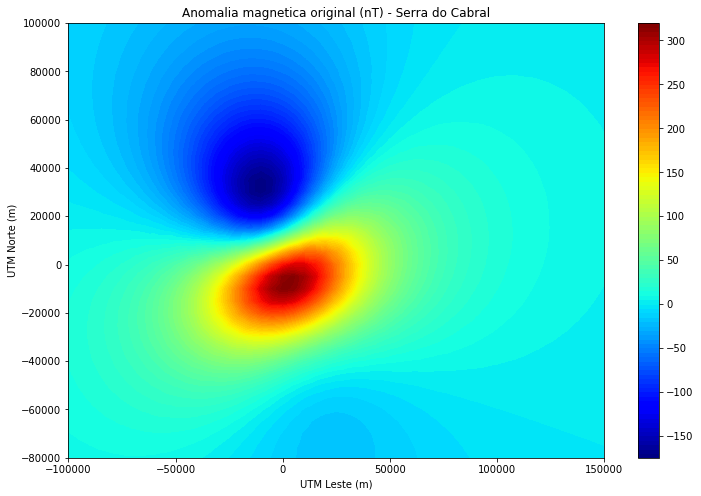

In [6]:
# Mostra o mapa original
plt.close('all')
plt.figure(figsize=(12,8))
plt.tricontourf(y, x, z, 100, cmap = plt.cm.jet)
plt.title('Anomalia magnetica original (nT) - Serra do Cabral')
plt.xlabel('UTM Leste (m)')
plt.ylabel('UTM Norte (m)')
plt.colorbar()

plt.savefig('fig01_dadomag_original.png')
plt.show()

In [7]:
# Nova area e novo shape para o dado
area = [x.min(), x.max(), y.min(), y.max()]
shape = (50, 50)

In [8]:
# Interpolando o dado
xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
xnew, ynew = np.meshgrid(xi, yi)

In [9]:
# Uso do grid data
znew = griddata((x, y), z, (xnew, ynew))

In [10]:
# Estatistica do dado
print 'Dado magnetico gridado:'
_ = analysis(znew, 'nT')

Dado magnetico gridado:
Minimum:    -170.7816 nT
Maximum:    314.4277 nT
Mean value: 10.1863 nT
Variation:  485.2094 nT


In [11]:
print 'Diferenca de maximo (nT):', np.abs(znew.max() - z.max())
print 'Diferenca de minimo (nT):', np.abs(znew.min() - z.min())
print 'Diferenca de medias (nT):', np.abs(znew.mean() - z.mean())

Diferenca de maximo (nT): 2.93526530612
Diferenca de minimo (nT): 2.14636734694
Diferenca de medias (nT): 0.125978114277


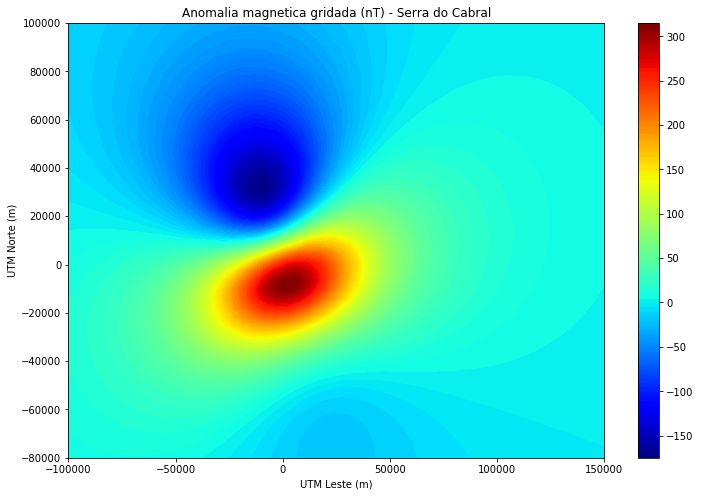

In [12]:
plt.close('all')
plt.figure(figsize=(12,8))
plt.contourf(ynew, xnew, znew, 100, cmap = plt.cm.jet)
plt.title('Anomalia magnetica gridada (nT) - Serra do Cabral')
plt.xlabel('UTM Leste (m)')
plt.ylabel('UTM Norte (m)')
plt.colorbar()

plt.savefig('fig02_dadomag_gridado.png')
plt.show()

## Teste para redução ao Polo

In [13]:
# Valores informados no trabalho (Cosme)
inc, dec = -17., -17.5
incs, decs = 59., -48.
polo = (90., 0.)

In [14]:
from codes.filtering import reduction
from fatiando.gravmag.transform import reduce_to_pole

/home/nielsen/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [15]:
# Reducao ao Polo calculada atraves das funcoes 
rtp_n = reduction(xnew, ynew, znew, (inc, dec), (incs, decs), polo, polo)

codes/auxiliars.py:190: RuntimeWarning: invalid value encountered in divide
  theta = z + ((x*u + y*v)/k)*1j


In [16]:
x_fa, y_fa, z_fa = xnew.reshape(xnew.size), ynew.reshape(ynew.size), znew.reshape(xnew.size)

In [17]:
# Reducao ao Polo calculada via Fatiando
rtp_f = reduce_to_pole(x_fa, y_fa, z_fa, (50, 50), incs, decs, incs, decs)

In [18]:
print 'Reducao via funcoes:'
_ = analysis(rtp_n, 'nT')

Reducao via funcoes:
Minimum:    -267.9180 nT
Maximum:    370.0671 nT
Mean value: -0.0000 nT
Variation:  637.9852 nT


In [19]:
print 'Reducao via fatiando:'
_ = analysis(rtp_f, 'nT')

Reducao via fatiando:
Minimum:    -273.8696 nT
Maximum:    284.7100 nT
Mean value: -0.0000 nT
Variation:  558.5795 nT


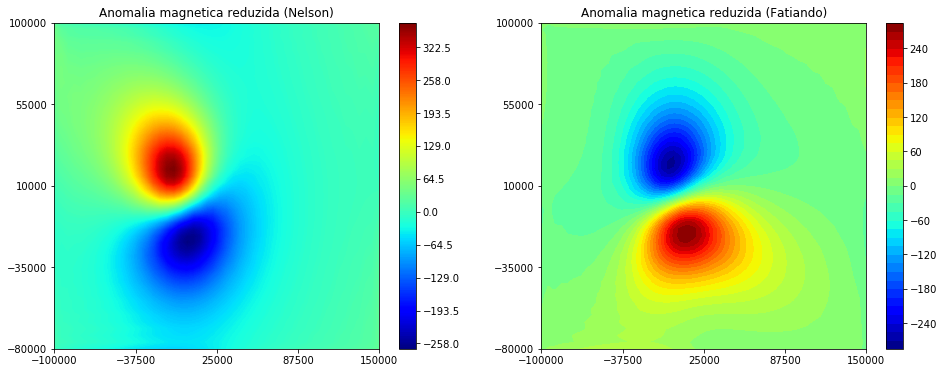

In [20]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.contourf(ynew, xnew, rtp_n, 520, cmap = plt.cm.jet)
plt.title('Anomalia magnetica reduzida (Nelson)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.contourf(ynew, xnew, rtp_f.reshape(shape), 50, cmap = plt.cm.jet)
plt.title('Anomalia magnetica reduzida (Fatiando)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('fig03_reducao_original.png')

plt.show()

## Teste para a Correlacao Cruzada

In [21]:
from codes.statistical import cccoef

### (1) TGA e VG do dado reduzido ao Polo

In [22]:
from codes.derivative import totalgrad, horzgrad, zderiv
from codes.filtering import pseudograv

In [23]:
tga_data = totalgrad(xi, yi, znew)
vga_data = zderiv(xi, yi, znew, 1.)
tga_rtp = totalgrad(xi, yi, rtp_n)
vga_rtp = zderiv(xi, yi, rtp_n, 1)

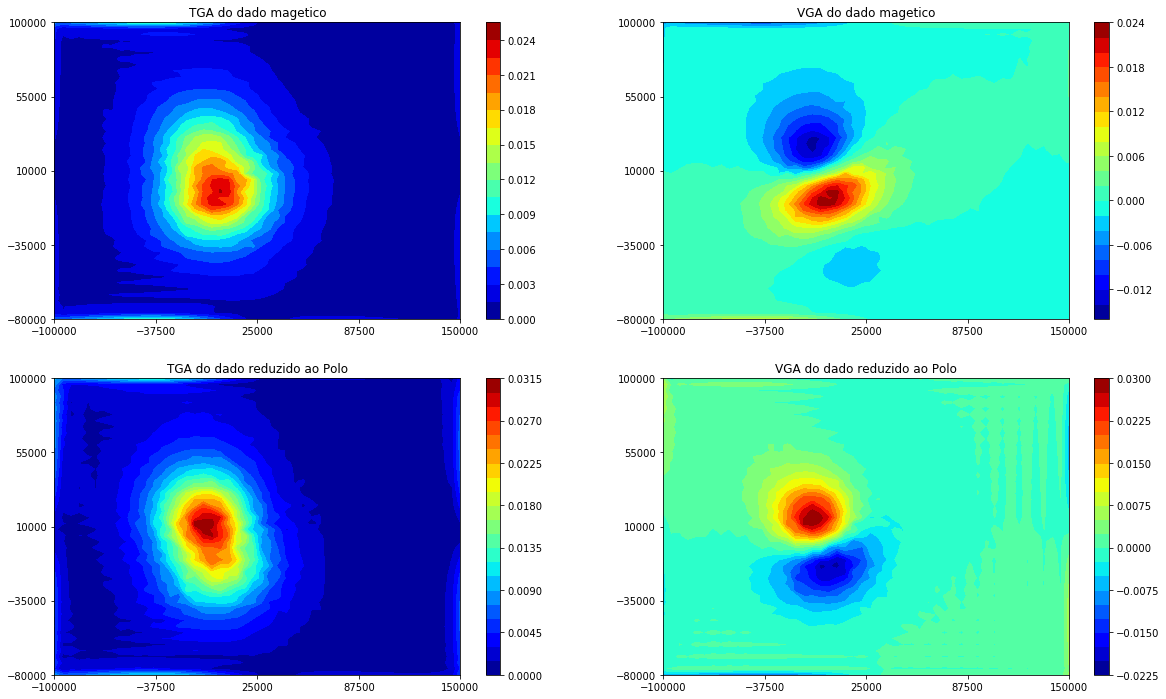

In [24]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.contourf(ynew, xnew, tga_data, 20, cmap = plt.cm.jet)
plt.title('TGA do dado magetico')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(ynew, xnew, vga_data, 20, cmap = plt.cm.jet)
plt.title('VGA do dado magetico')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 3)
plt.contourf(ynew, xnew, tga_rtp, 20, cmap = plt.cm.jet)
plt.title('TGA do dado reduzido ao Polo')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(ynew, xnew, vga_rtp, 20, cmap = plt.cm.jet)
plt.title('VGA do dado reduzido ao Polo')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('fig04_mapa_tga_hga.png')

plt.show()

In [25]:
# Intervalos de inclinacao e declinacao
ip = np.arange(20., 91.)
im = np.arange(-90., -19.)
d = np.arange(-150., 151.)
D, Ip = np.meshgrid(d, ip)
_, Im = np.meshgrid(d, im)

# Cria a matriz de coeficientes
cc_plus = np.zeros((ip.size, d.size))
cc_minus = np.zeros((im.size, d.size))

In [26]:
# Calculando a correlacao para inclinacao positiva
for ki in range(ip.size):
    for kd in range(d.size):
        rtp = reduction(xnew, ynew, znew, (inc, dec), (ip[ki], d[kd]), polo, polo)
        tga = totalgrad(xi, yi, rtp)
        vga = zderiv(xi, yi, rtp, 1)
        cc_plus[ki, kd] = cccoef(tga, vga)

In [27]:
# Calculando a correlacao para inclinacao positiva
for ki in range(im.size):
    for kd in range(d.size):
        rtp = reduction(xnew, ynew, znew, (inc, dec), (im[ki], d[kd]), polo, polo)
        tga = totalgrad(xi, yi, rtp)
        vga = zderiv(xi, yi, rtp, 1)
        cc_minus[ki, kd] = cccoef(tga, vga)

In [28]:
# Analisando os valores de maximo e minimo
print 'Intervalo para inclinacao positiva:'
_ = analysis(cc_plus)
print '---------------'
print 'Intervalo para inclinacao negativa:'
_ = analysis(cc_minus)

Intervalo para inclinacao positiva:
Minimum:    0.0060
Maximum:    0.7716
Mean value: 0.3329
Variation:  0.7656
---------------
Intervalo para inclinacao negativa:
Minimum:    -0.7902
Maximum:    -0.0324
Mean value: -0.3953
Variation:  0.7578


In [29]:
# Find the index
maxi1, mini1 = find_index(cc_plus)
imax1, jmax1 = maxi1
imin1, jmin1 = mini1

In [30]:
# Find the index
maxi2, mini2 = find_index(cc_minus)
imax2, jmax2 = maxi2
imin2, jmin2 = mini2

In [31]:
print 'Indices maximos:', maxi1
print 'Indices minimos:', mini1
print 'Incl e Dec calculados (maximo):', Im[imax1, jmax1], D[imax1, jmax1]
print 'Incl e Dec calculados (minimo):', Im[imin1, jmin1], D[imin1, jmin1]

Indices maximos: (array([0]), array([300]))
Indices minimos: (array([0]), array([130]))
Incl e Dec calculados (maximo): [-90.] [ 150.]
Incl e Dec calculados (minimo): [-90.] [-20.]


In [32]:
print 'Indices maximos:', maxi2
print 'Indices minimos:', mini2
print 'Incl e Dec calculados (maximo):', Im[imax2, jmax2], D[imax2, jmax2]
print 'Incl e Dec calculados (minimo):', Im[imin2, jmin2], D[imin2, jmin2]

Indices maximos: (array([70]), array([300]))
Indices minimos: (array([70]), array([129]))
Incl e Dec calculados (maximo): [-20.] [ 150.]
Incl e Dec calculados (minimo): [-20.] [-21.]


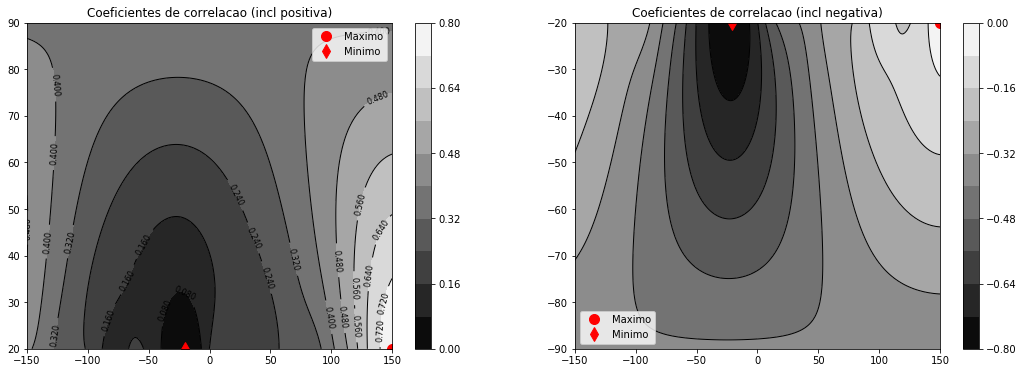

In [33]:
# Plotando os coeficientes calculados
plt.close('all')
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plot1 = plt.contour(D, Ip, cc_plus, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.clabel(plot1, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contourf(D, Ip, cc_plus, 10, cmap = plt.cm.gray)
plt.plot(D[imax1, jmax1], Ip[imax1, jmax1], 'ro', markersize = 10, label = 'Maximo')
plt.plot(D[imin1, jmin1], Ip[imin1, jmin1], 'rd', markersize = 10, label = 'Minimo')
plt.title('Coeficientes de correlacao (incl positiva)')
plt.legend(loc = 'upper right')
plt.colorbar()

plt.subplot(1, 2, 2)
plot2 = plt.contour(D, Im, cc_minus, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.clabel(plot1, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contourf(D, Im, cc_minus, 10, cmap = plt.cm.gray)
plt.plot(D[imax2, jmax2], Im[imax2, jmax2], 'ro', markersize = 10, label = 'Maximo')
plt.plot(D[imin2, jmin2], Im[imin2, jmin2], 'rd', markersize = 10, label = 'Minimo')
plt.title('Coeficientes de correlacao (incl negativa)')
plt.legend(loc = 'lower left')
plt.colorbar()

plt.savefig('fig05_correlacao_tga_vga.png')
plt.show()

In [34]:
# Calcula a reducao ao Polo para os valores de maximo e minimo encontrados
rtp_max_plus = reduction(xi, yi, znew, (inc, dec), (D[imax1, jmax1], Ip[imax1, jmax1]), polo, polo)
rtp_min_plus = reduction(xi, yi, znew, (inc, dec), (D[imin1, jmin1], Ip[imin1, jmin1]), polo, polo)

# Calcula a reducao ao Polo para os valores de maximo e minimo encontrados
rtp_max_minus = reduction(xi, yi, znew, (inc, dec), (D[imax2, jmax2], Im[imax2, jmax2]), polo, polo)
rtp_min_minus = reduction(xi, yi, znew, (inc, dec), (D[imin2, jmin2], Im[imin2, jmin2]), polo, polo)

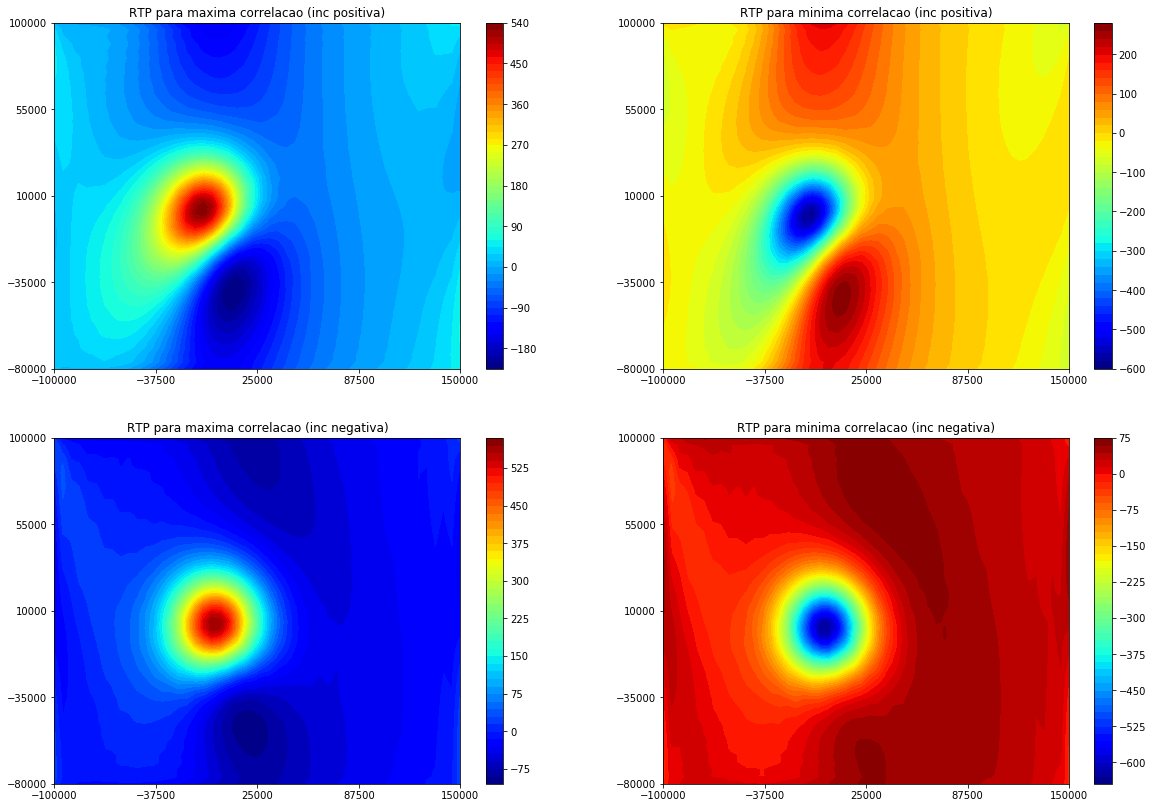

In [35]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.contourf(ynew, xnew, rtp_max_plus, 50, cmap = plt.cm.jet)
plt.title('RTP para maxima correlacao (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(ynew, xnew, rtp_min_plus, 50, cmap = plt.cm.jet)
plt.title('RTP para minima correlacao (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()
          
plt.subplot(2, 2, 3)
plt.contourf(ynew, xnew, rtp_max_minus, 50, cmap = plt.cm.jet)
plt.title('RTP para maxima correlacao (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(ynew, xnew, rtp_min_minus, 50, cmap = plt.cm.jet)
plt.title('RTP para minima correlacao (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('fig06_reducao_calculada(tga-vga).png')

plt.show()

In [36]:
# Calculo do dado pseudogravimetrico
ps_max_plus = pseudograv(xi, yi, znew, (inc, dec), (D[imax1, jmax1], Ip[imax1, jmax1]), 1000., 1.)
ps_min_plus = pseudograv(xi, yi, znew, (inc, dec), (D[imin1, jmin1], Ip[imin1, jmin1]), 1000., 1.)
# Calculo do dado pseudogravimetrico
ps_max_minus = pseudograv(xi, yi, znew, (inc, dec), (D[imax2, jmax2], Im[imax2, jmax2]), 1000., 1.)
ps_min_minus = pseudograv(xi, yi, znew, (inc, dec), (D[imin2, jmin2], Im[imin2, jmin2]), 1000., 1.)

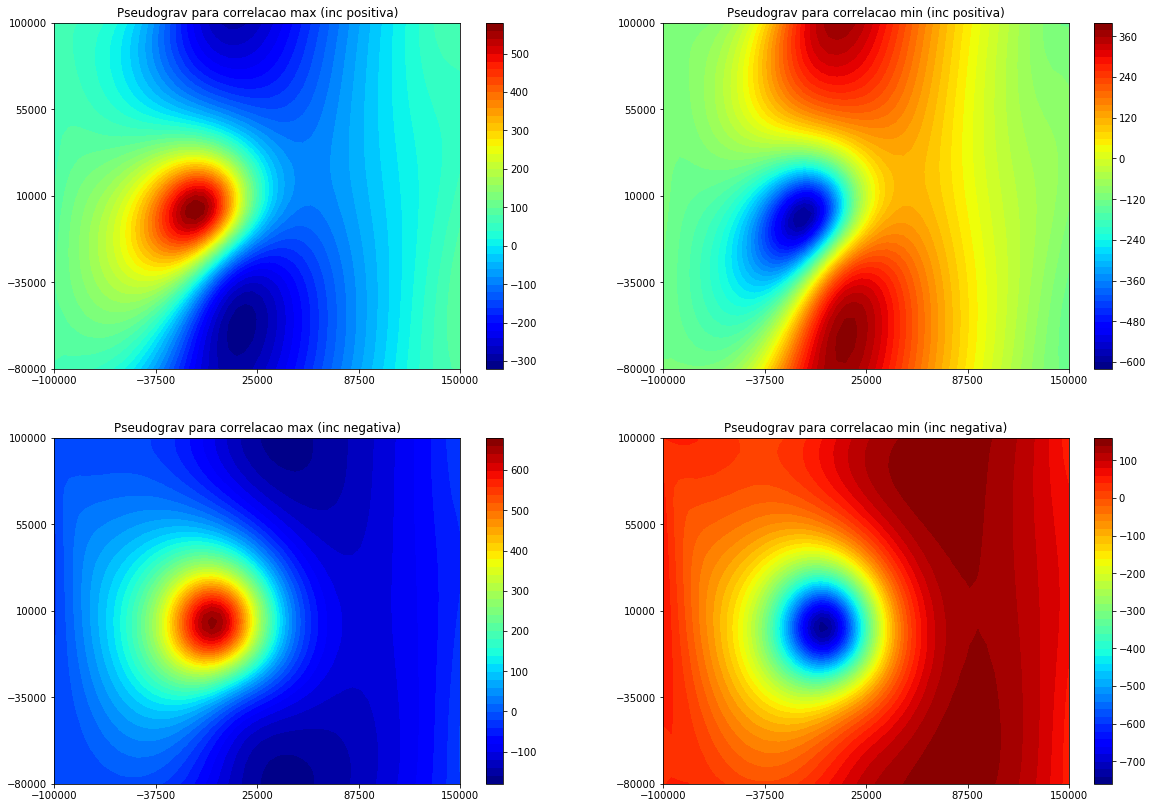

In [37]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.contourf(ynew, xnew, ps_max_plus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao max (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(ynew, xnew, ps_min_plus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao min (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()
          
plt.subplot(2, 2, 3)
plt.contourf(ynew, xnew, ps_max_minus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao max (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(ynew, xnew, ps_min_minus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao min (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('fig07_pseudograv(tga_vga).png')

plt.show()

### (2) TGA do dado reduzido ao Polo e HGA do dado pseudogravimetrico

In [38]:
# Intervalos de inclinacao e declinacao
ip = np.arange(20., 91.)
im = np.arange(-90., -19.)
d = np.arange(-150., 151.)
D, Ip = np.meshgrid(d, ip)
_, Im = np.meshgrid(d, im)

# Cria a matriz de coeficientes
cc_plus = np.zeros((ip.size, d.size))
cc_minus = np.zeros((im.size, d.size))

In [39]:
# Cria a matriz de coeficientes
cc_plus = np.zeros((ip.size, d.size))
cc_minus = np.zeros((im.size, d.size))

In [40]:
# Calculando a correlacao para inclinacao positiva
for ki in range(ip.size):
    for kd in range(d.size):
        rtp = reduction(xnew, ynew, znew, (inc, dec), (ip[ki], d[kd]), polo, polo)
        pgrav = pseudograv(xnew, ynew, rtp, polo, polo, 1000., 1.)
        tga = totalgrad(xi, yi, rtp)
        hga = horzgrad(xi, yi, pgrav)
        cc_plus[ki, kd] = cccoef(tga, hga)

In [41]:
# Calculando a correlacao para inclinacao positiva
for ki in range(im.size):
    for kd in range(d.size):
        rtp = reduction(xnew, ynew, znew, (inc, dec), (im[ki], d[kd]), polo, polo)
        pgrav = pseudograv(xnew, ynew, rtp, polo, polo, 1000., 1.)
        tga = totalgrad(xi, yi, rtp)
        hga = horzgrad(xi, yi, pgrav)
        cc_minus[ki, kd] = cccoef(tga, hga)

In [42]:
# Analisando os valores de maximo e minimo
print 'Intervalo para inclinacao positiva:'
_ = analysis(cc_plus)
print '---------------'
print 'Intervalo para inclinacao negativa:'
_ = analysis(cc_minus)

Intervalo para inclinacao positiva:
Minimum:    0.7226
Maximum:    0.8176
Mean value: 0.7915
Variation:  0.0950
---------------
Intervalo para inclinacao negativa:
Minimum:    0.7079
Maximum:    0.8176
Mean value: 0.7870
Variation:  0.1097


In [43]:
# Find the index
maxi1, mini1 = find_index(cc_plus)
imax1, jmax1 = maxi1
imin1, jmin1 = mini1

# Find the index
maxi2, mini2 = find_index(cc_minus)
imax2, jmax2 = maxi2
imin2, jmin2 = mini2

In [44]:
print 'Indices maximos:', maxi1
print 'Indices minimos:', mini1
print 'Incl e Dec calculados (maximo):', Im[imax1, jmax1], D[imax1, jmax1]
print 'Incl e Dec calculados (minimo):', Im[imin1, jmin1], D[imin1, jmin1]

print 'Indices maximos:', maxi2
print 'Indices minimos:', mini2
print 'Incl e Dec calculados (maximo):', Im[imax2, jmax2], D[imax2, jmax2]
print 'Incl e Dec calculados (minimo):', Im[imin2, jmin2], D[imin2, jmin2]

Indices maximos: (array([21]), array([81]))
Indices minimos: (array([0]), array([137]))
Incl e Dec calculados (maximo): [-69.] [-69.]
Incl e Dec calculados (minimo): [-90.] [-13.]
Indices maximos: (array([49]), array([261]))
Indices minimos: (array([70]), array([137]))
Incl e Dec calculados (maximo): [-41.] [ 111.]
Incl e Dec calculados (minimo): [-20.] [-13.]


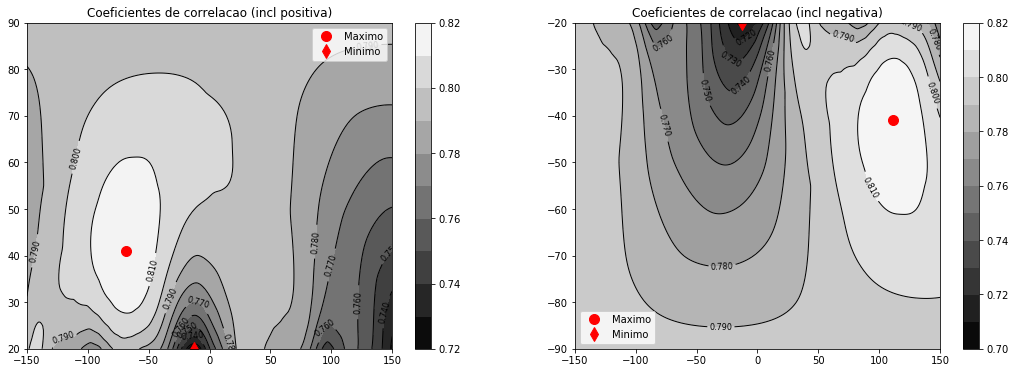

In [45]:
# Plotando os coeficientes calculados
plt.close('all')
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plot1 = plt.contour(D, Ip, cc_plus, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.clabel(plot1, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contourf(D, Ip, cc_plus, 10, cmap = plt.cm.gray)
plt.plot(D[imax1, jmax1], Ip[imax1, jmax1], 'ro', markersize = 10, label = 'Maximo')
plt.plot(D[imin1, jmin1], Ip[imin1, jmin1], 'rd', markersize = 10, label = 'Minimo')
plt.title('Coeficientes de correlacao (incl positiva)')
plt.legend(loc = 'upper right')
plt.colorbar()

plt.subplot(1, 2, 2)
plot2 = plt.contour(D, Im, cc_minus, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.clabel(plot2, fontsize = 8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contourf(D, Im, cc_minus, 10, cmap = plt.cm.gray)
plt.plot(D[imax2, jmax2], Im[imax2, jmax2], 'ro', markersize = 10, label = 'Maximo')
plt.plot(D[imin2, jmin2], Im[imin2, jmin2], 'rd', markersize = 10, label = 'Minimo')
plt.title('Coeficientes de correlacao (incl negativa)')
plt.legend(loc = 'lower left')
plt.colorbar()

plt.savefig('fig08_correlacao_tga_hga.png')
plt.show()

In [46]:
# Calcula a reducao ao Polo para os valores de maximo e minimo encontrados
rtp_max_plus = reduction(xi, yi, znew, (inc, dec), (D[imax1, jmax1], Ip[imax1, jmax1]), polo, polo)
rtp_min_plus = reduction(xi, yi, znew, (inc, dec), (D[imin1, jmin1], Ip[imin1, jmin1]), polo, polo)

# Calcula a reducao ao Polo para os valores de maximo e minimo encontrados
rtp_max_minus = reduction(xi, yi, znew, (inc, dec), (D[imax2, jmax2], Im[imax2, jmax2]), polo, polo)
rtp_min_minus = reduction(xi, yi, znew, (inc, dec), (D[imin2, jmin2], Im[imin2, jmin2]), polo, polo)

In [47]:
# Calculo do dado pseudogravimetrico
ps_max_plus = pseudograv(xi, yi, znew, (inc, dec), (D[imax1, jmax1], Ip[imax1, jmax1]), 1000., 1.)
ps_min_plus = pseudograv(xi, yi, znew, (inc, dec), (D[imin1, jmin1], Ip[imin1, jmin1]), 1000., 1.)
# Calculo do dado pseudogravimetrico
ps_max_minus = pseudograv(xi, yi, znew, (inc, dec), (D[imax2, jmax2], Im[imax2, jmax2]), 1000., 1.)
ps_min_minus = pseudograv(xi, yi, znew, (inc, dec), (D[imin2, jmin2], Im[imin2, jmin2]), 1000., 1.)

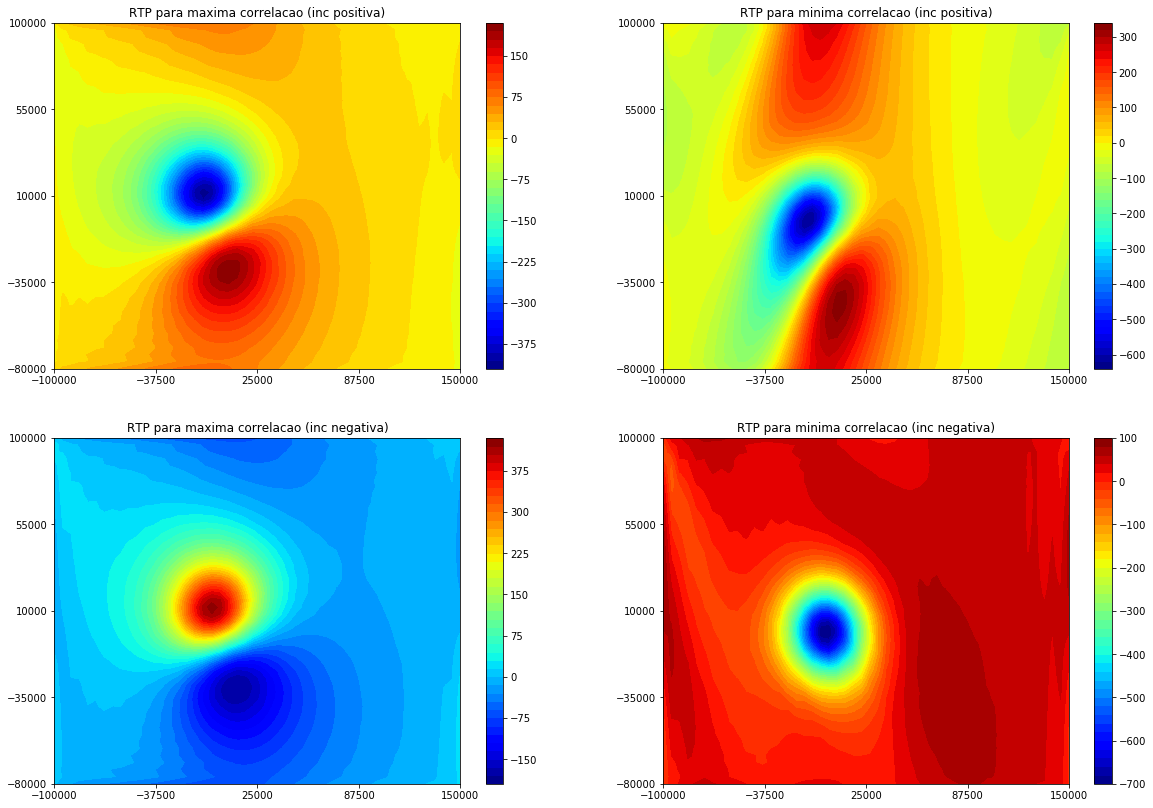

In [48]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.contourf(ynew, xnew, rtp_max_plus, 50, cmap = plt.cm.jet)
plt.title('RTP para maxima correlacao (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(ynew, xnew, rtp_min_plus, 50, cmap = plt.cm.jet)
plt.title('RTP para minima correlacao (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()
          
plt.subplot(2, 2, 3)
plt.contourf(ynew, xnew, rtp_max_minus, 50, cmap = plt.cm.jet)
plt.title('RTP para maxima correlacao (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(ynew, xnew, rtp_min_minus, 50, cmap = plt.cm.jet)
plt.title('RTP para minima correlacao (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('fig09_reducao_calculada(tga_hga).png')

plt.show()

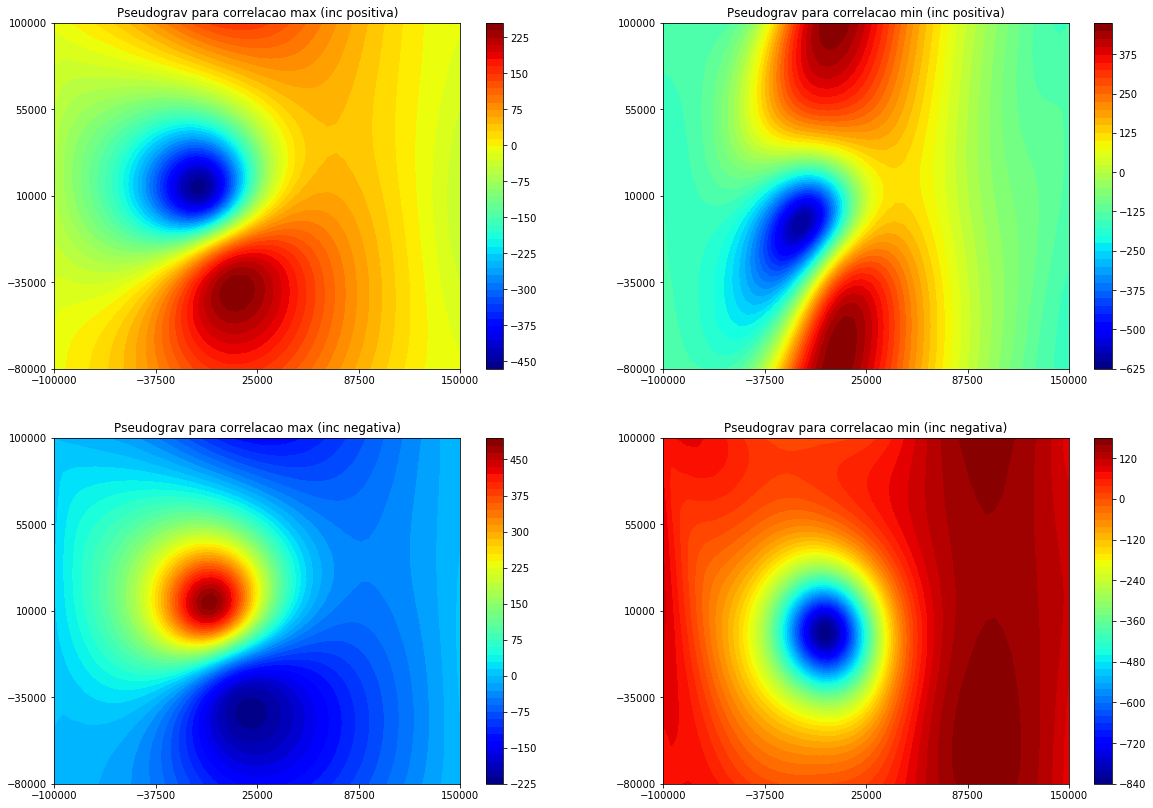

In [49]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.contourf(ynew, xnew, ps_max_plus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao max (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(ynew, xnew, ps_min_plus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao min (inc positiva)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()
          
plt.subplot(2, 2, 3)
plt.contourf(ynew, xnew, ps_max_minus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao max (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(ynew, xnew, ps_min_minus, 50, cmap = plt.cm.jet)
plt.title('Pseudograv para correlacao min (inc negativa)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('fig10_pseudograv(tga_hga).png')

plt.show()